# =============================================================================
# Script for spectral paramaterization and analysis of cleaned and epoched EEG data from
# Rygvold T, Hatlestad-Hall C et al. (2021): http://dx.doi.org/10.1111/ejn.14964. SRM Resting-state EEG.
# "DatasetDOI": "10.18112/openneuro.ds003775.v1.0.0"
#
# Created by Daniel J McKeown, Bond University, 2024.
# =============================================================================

In [2]:
import os
import os.path as op
import numpy as np
import pandas as pd
import copy
import mne
import mne_icalabel
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from mne.viz import plot_topomap
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

#Define the home directory where the data is stored
home_dir = op.realpath(op.join(op.abspath(''), '..', 'Data')) 

#Set the monthage,channel information, frequency range and frequency bands
montage = mne.channels.make_standard_montage('biosemi64')
chan_info = mne.io.read_epochs_eeglab(home_dir + r"\info.set")
chan_info = chan_info.info
adjacency, _ = mne.channels.find_ch_adjacency(chan_info, ch_type='eeg')
freq_range = [1, 50]
bands = Bands({'delta': [1,4], 'theta': [4, 8], 'alpha': [8, 13], 'beta': [13, 30], 'gamma': [50, 100]})

C:\Users\Hypox\AppData\Local\Temp\ipykernel_19544\534216874.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


Extracting parameters from C:\Users\Hypox\OneDrive - Bond University\Aperiodic Signals and Disorders\srm_cognition\dan_analysis\manuscript\github\Data\info.set...
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Ready.
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# =============================================================================
# Function for spectral parameterisation of EEG data using provided cleaned and epoched data 
# from Rygvold T, Hatlestad-Hall C et al. (2021)
# =============================================================================

In [ ]:
#Function to loop through the EEG data and perform FOOOF/SPECPARAM analysis
def fooof_eeg_loop(psd_args):

    if not 'epochpath' in psd_args:
        raise ValueError('Preprocessed path not specified, where is the preprocessed data?')

    if not 'psdpath' in psd_args:
        raise ValueError('Epoch path not specified, where should the epoched data go?')

    epochpath = psd_args['epochpath']
    psdpath = psd_args['psdpath']

    print(epochpath)
    print(psdpath)

    # Modify subject_folders to start from the specified startsubj index
    subject_folders = [f.name for f in os.scandir(psd_args['epochpath']) if f.is_dir() and f.name.startswith('sub-')]
    subject_folders = subject_folders[startsubj:]

    for subject_folder in os.listdir(epochpath):
        subject_path = op.join(epochpath, subject_folder)
        
        if not op.isdir(subject_path):
            continue

        sub_id = subject_folder.split('-')[1]
            
        for session_folder in ['ses-t1']:
            session_path = op.join(subject_path, session_folder)
            
            if not op.exists(session_path):
                continue

            eeg_path = op.join(session_path, 'eeg')
            
            if not op.exists(eeg_path):
                continue

            set_files = [f for f in os.listdir(eeg_path) if f.endswith('.set')] 
                
            for set_file in set_files:
                try:
                    set_path = op.join(eeg_path, set_file)
                    epoched_eeg_data = mne.read_epochs_eeglab(set_path)
                    avg_epochs = epoched_eeg_data.average()
                    fmax = 1 / (2 * (1 / avg_epochs.info['sfreq']))
                    psd = avg_epochs.compute_psd(method='welch', n_fft=300, n_overlap=150, fmin = 1, fmax = fmax)

                    # Extract frequency and power values
                    freqs = psd._freqs
                    psd = psd._data
                    delta_total = psd[:, np.where((freqs >= 1) & (freqs <= 4))[0]].mean(axis=1)
                    theta_total = psd[:, np.where((freqs >= 4) & (freqs <= 8))[0]].mean(axis=1)
                    alpha_total = psd[:, np.where((freqs >= 8) & (freqs <= 13))[0]].mean(axis=1)
                    beta_total = psd[:, np.where((freqs >= 13) & (freqs <= 30))[0]].mean(axis=1)
                    gamma_total = psd[:, np.where((freqs >= 50) & (freqs <= 100))[0]].mean(axis=1)
                
                    # Perform FOOOFGroup analysis
                    fg = FOOOFGroup(peak_width_limits=[1.6, 6], min_peak_height=0.05, peak_threshold=1.5, max_n_peaks=8, aperiodic_mode='fixed')
                    exps_temp = fg.get_params('aperiodic_params', 'exponent')
                    offset_temp = fg.get_params('aperiodic_params', 'offset')
                    peaks_temp = list(fg.get_params('peak_params'))
                    r_squ_temp = fg.get_params('r_squared')
                    delta_fooof = get_band_peak_fg(fg, bands['delta'])
                    theta_fooof = get_band_peak_fg(fg, bands['theta'])
                    alpha_fooof = get_band_peak_fg(fg, bands['alpha'])
                    beta_fooof = get_band_peak_fg(fg, bands['beta'])
                    gamma_fooof = get_band_peak_fg(fg, bands['gamma'])

                    # Store results in the dictionary
                    results['ID'].append(sub_id)
                    results['exponent'].append(exps_temp)
                    results['offset'].append(offset_temp)
                    results['peaks'].append(peaks_temp)
                    results['r2'].append(r_squ_temp)
                    results['total']['delta'].append(delta_total)
                    results['total']['theta'].append(theta_total)
                    results['total']['alpha'].append(alpha_total)
                    results['total']['beta'].append(beta_total)
                    results['total']['gamma'].append(gamma_total)
                    results['fooof']['delta'].append(delta_fooof)
                    results['fooof']['theta'].append(theta_fooof)
                    results['fooof']['alpha'].append(alpha_fooof)
                    results['fooof']['beta'].append(beta_fooof)
                    results['fooof']['gamma'].append(gamma_fooof)
                except Exception as e:
                    print(f"Error processing Subject: {subject_folder}, Session: {session_folder}, File: {fif_file}")
                    print(f"Error message: {str(e)}")
                    continue
    
    return results

# =============================================================================
# Other functions for analysis
# =============================================================================

In [3]:
#Functions for creating and manipulating dictionaries of fits#
def bad_fits(fit):
    """
    Return the number of fits below .90.
    """
    return np.sum(fit < .9)

def bad_fits_mask(fit):
    """
    Create a mask for the channels that have fits below .90.
    """
    return np.array(fit) < .9
  
def replace_bad_fits(fit, mask):
    """
    Replace bad fits in each dictionary entry with nans using the mask function.
    """
    return np.where(mask, np.nan, fit)

def replace_bad_fits_all(fit, mask):
    """
    Make the above into a function
    """
    fit['r2'] = replace_bad_fits(fit['r2'], mask)
    return fit


#Function for replacing nans with the mean or zero
def replace_nans(data, nan_policy='mean', min_valid_percentage=0):
    """
    Replace NaN values in a pandas Series or NumPy array with either the mean or zero.

    Parameters:
    data (Series or array-like): The input pandas Series or NumPy array.
    nan_policy (str): The policy to replace NaNs. Options are 'mean' or 'zero'.
    min_valid_percentage (float): The minimum valid percentage required for replacing NaNs.

    Returns:
    Series or array-like: Data with NaNs replaced.
    """
    if isinstance(data, pd.Series):
        non_nan_count = data.notna().sum()
        total_elements = data.shape[0]
    elif isinstance(data, np.ndarray):
        non_nan_count = np.count_nonzero(~np.isnan(data))
        total_elements = data.size
    else:
        raise ValueError("Input must be a pandas Series or NumPy array.")

    non_nan_percentage = non_nan_count / total_elements

    if non_nan_percentage >= (min_valid_percentage / 100):
        if nan_policy == 'mean':
            if isinstance(data, pd.Series):
                return data.fillna(data.mean())
            elif isinstance(data, np.ndarray):
                mean_value = np.nanmean(data)
                return np.where(np.isnan(data), mean_value, data)
        elif nan_policy == 'zero':
            if isinstance(data, pd.Series):
                return data.fillna(0)
            elif isinstance(data, np.ndarray):
                return np.nan_to_num(data, nan=0)
        else:
            raise ValueError('Nan policy not understood.')
    else:
        return data


#Function for adding electrode prefix to variable names in DataFrame
def add_electrode_prefix(data, chan_info, variable_name):
    """
    Add electrode prefix to variable names in DataFrame.
    """
    for column in data.columns[1:]:
        electrode_names = chan_info['ch_names']
        new_column_names = [f"{electrode}_{variable_name}" for electrode in electrode_names]
        data.rename(columns={column: new_column_names[data.columns.get_loc(column) - 1]}, inplace=True)
    return data


#Function for plotting clusters on topomap
def plot_cluster_topomap(mask, cluster_name, cmap):
    """
    Function to plot topomap for a cluster with a specific color map.
    """
    cluster_electrodes = np.array(chan_names)[mask]
    cluster_positions = {elec: positions[elec] for elec in cluster_electrodes if elec in positions}
    data = np.zeros(len(chan_names))
    data[mask] = 1
    pos = np.array([positions[elec][:2] for elec in chan_names if elec in positions])
    info = mne.create_info(ch_names=chan_names, sfreq=1000, ch_types="eeg")
    info.set_montage(montage)
    fig, ax = plt.subplots()
    mne.viz.plot_topomap(data, pos=pos, names=chan_names, axes=ax, contours=0, size=15, cmap=cmap, extrapolate='box')
    ax.set_title(cluster_name)
    plt.show()


#Class for KMeans Clustering
class KMeansClustering:

    def __init__(self, k=6):
        self.k = k
        self.centroids = None

    @staticmethod
    def euclidean_distance(data_point, centroids):
        return np.sqrt(np.sum((centroids - data_point)**2, axis=1))

    def fit(self, X, max_iterations=400, random_state=None):
        if random_state is not None:
            np.random.seed(random_state)
        
        self.centroids = np.random.uniform(np.amin(X, axis=0), np.amax(X, axis=0),
            size=(self.k, X.shape[1]))
        
        for _ in range(max_iterations):
            y = []

            for data_point in X:
                distances = KMeansClustering.euclidean_distance(data_point, self.centroids)
                cluster_num = np.argmin(distances)
                y.append(cluster_num)

            y = np.array(y)

            cluster_indices =[]

            for i in range(self.k):
                cluster_indices.append(np.argwhere(y ==i))

            cluster_centers = []

            for i, indices in enumerate(cluster_indices):
                if len(indices) ==0:
                    cluster_centers.append(self.centroids[i])
                else:
                    cluster_centers.append(np.mean(X[indices], axis=0)[0])

            if np.max(self.centroids - np.array(cluster_centers)) < 0.0001:
                break
            else:
                self.centroids = np.array(cluster_centers)

        return y
    

In [ ]:
#Create a dictionary to store the results
results = {
    'ID': [],
    'exponent': [],
    'offset': [],
    'peaks': [],
    'r2': [],
    'total': {
        'delta': [],
        'theta': [],
        'alpha': [],
        'beta': [],
        'gamma': []
    },
    'fooof': {
        'delta': [],
        'theta': [],
        'alpha': [],
        'beta': [],
        'gamma': []
    }
}

#Args for parameterization
#If you have got the data from Rygvold T, Hatlestad-Hall C et al. (2021): http://dx.doi.org/10.1111/ejn.14964. SRM Resting-state EEG. Will be organised in this BIDS structure
#Create a folder to store the results of the FOOOF analysis
psd_args = {
    'epochpath': home_dir + r'\derivatives\cleaned_data', 
    'psdpath': home_dir + r'\derivatives\fooof_data', 
}

#Set to None to process all subjects, or specify a subject if needed
subject = None  
# Set the starting subject index
startsubj = 0 
#List the subjects in the sourcepath with the prefix sub-
subject_folders = [f.name for f in os.scandir(psd_args['psdpath']) if f.is_dir() and f.name.startswith('sub-')]

In [ ]:
#If you want to start parameterization from a specific subject, you can use the following code
subject_identifier = 'sub-020'
try:
    startsubj_index = subject_folders.index(subject_identifier)
    print(f"The index for {subject_identifier} is: {startsubj_index}")
except ValueError:
    print(f"{subject_identifier} is not found in the subject folders.")
    #Set a default index to handle the case as needed
    startsubj_index = 0 

In [ ]:
#Run the function to perform the FOOOF analysis
results = fooof_eeg_loop(psd_args)

# Save the results to npy files
results = results[0]
np.save(home_dir + r'\results.npy', results)

# =============================================================================
# Data quality and reduction
# =============================================================================

In [5]:
#Load in the results of the parameterisation and demographic data provided by Hatlestad-Hall C et al. (2021)
results = np.load(home_dir + r"\results.npy", allow_pickle=True).tolist()
demo_data = pd.read_csv(home_dir + r"\demo_data.csv")

average r2: 0.9859781083878699
std r2: 0.005057488247671305


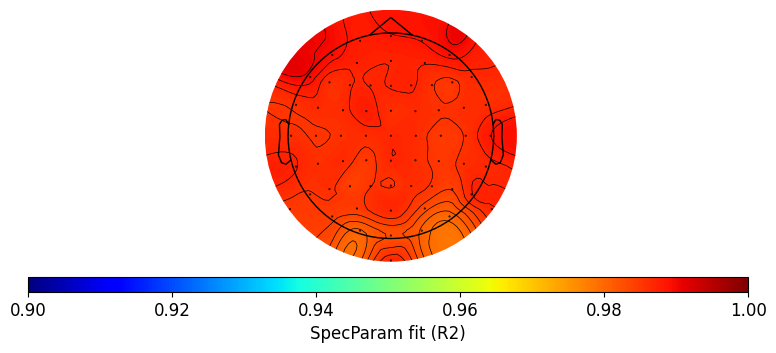

In [14]:
#How well does the FOOOF model fit the data?
fig, ax = plt.subplots(figsize=(10, 5))
vlim = (.9, 1)
im, cm = plot_topomap(np.mean(np.array(results['r2']), axis=0), chan_info, size=5, cmap='jet', show=False, contours=10, image_interp='cubic', axes=ax, vlim=vlim)
cbar_ax = fig.add_axes([0.15, 0.01, 0.72, 0.05])
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('SpecParam fit (R2)', fontsize=12)
cbar.ax.tick_params(labelsize=12)
fig.set_size_inches(10,3)
fig.subplots_adjust(wspace=0.05, hspace=0.2)

#what is the average r2 value across all participants and all channels?
print( 'average r2:', np.mean(np.mean(np.array(results['r2']), axis=0)))
print( 'std r2:', np.std(np.std(np.array(results['r2']), axis=0)))

In [20]:
#Replace bad fits with NaNs
results = replace_bad_fits_all(results, bad_fits_mask(results['r2']))

#Which participants have more than 50% of their channels with bad fits?_nan_mask = np.sum(np.isnan(results['r2']).squeeze(),axis=1)/64 > .5
nan_mask  = np.sum(np.isnan(results['r2']).squeeze(),axis=1)/64 > .5

#Reverse the mask to get the good fits_good_mask = _nan_mask
good_mask = ~nan_mask

#How many participants have more than 50% of their channels with bad fits?
print("Participants with >50% bad fits:",np.sum(nan_mask))

#Which IDs are in the good fits?_good_id = np.array(results['ID'])_good_mask].astype(int)
good_id = np.array(results['ID'])[good_mask].astype(int)

#How many IDs are in the good fits?
print("Good participants:", good_id)

Participants with >50% bad fits: 0
Good participants: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111]


In [21]:
#Calculate the number of NaNs in each measure for each participant in each group per electrode location
nan_count_exponent = np.sum(
    np.isnan(np.array(results['exponent']).squeeze()), axis=1)
nan_count_offset = np.sum(
    np.isnan(np.array(results['offset']).squeeze()), axis=1)

nan_count_total_delta_pw = np.sum(
    np.isnan(np.array(results['total']['delta']).squeeze()), axis=1)
nan_count_total_theta_pw = np.sum(
    np.isnan(np.array(results['total']['theta']).squeeze()), axis=1)
nan_count_total_alpha_pw = np.sum(
    np.isnan(np.array(results['total']['alpha']).squeeze()), axis=1)
nan_count_total_beta_pw = np.sum(
    np.isnan(np.array(results['total']['beta']).squeeze()), axis=1)
nan_count_total_gamma_pw = np.sum(
    np.isnan(np.array(results['total']['gamma']).squeeze()), axis=1)

nan_count_fooof_delta_pw = np.sum(
    np.isnan(np.array(results['fooof']['delta'])[:,:,0].squeeze()), axis=1)
nan_count_fooof_theta_pw = np.sum(
    np.isnan(np.array(results['fooof']['theta'])[:,:,0].squeeze()), axis=1)
nan_count_fooof_alpha_pw = np.sum(
    np.isnan(np.array(results['fooof']['alpha'])[:,:,0].squeeze()), axis=1)
nan_count_fooof_beta_pw = np.sum(
    np.isnan(np.array(results['fooof']['beta'])[:,:,0].squeeze()), axis=1)
nan_count_fooof_gamma_pw = np.sum(
    np.isnan(np.array(results['fooof']['gamma'])[:,:,0].squeeze()), axis=1)

#What is the proportion of retained channels for each measure?
prop_exponent = 100 - (nan_count_exponent.mean()/64)*100
prop_offset = 100 - (nan_count_offset.mean()/64)*100
prop_total_delta_pw = 100 - (nan_count_total_delta_pw.mean()/64)*100
prop_total_theta_pw = 100 - (nan_count_total_theta_pw.mean()/64)*100
prop_total_alpha_pw = 100 - (nan_count_total_alpha_pw.mean()/64)*100
prop_total_beta_pw = 100 - (nan_count_total_beta_pw.mean()/64)*100
prop_total_gamma_pw = 100 - (nan_count_total_gamma_pw.mean()/64)*100
prop_fooof_delta_pw = 100 - (nan_count_fooof_delta_pw.mean()/64)*100
prop_fooof_theta_pw = 100 - (nan_count_fooof_theta_pw.mean()/64)*100
prop_fooof_alpha_pw = 100 - (nan_count_fooof_alpha_pw.mean()/64)*100
prop_fooof_beta_pw = 100 - (nan_count_fooof_beta_pw.mean()/64)*100
prop_fooof_gamma_pw = 100 - (nan_count_fooof_gamma_pw.mean()/64)*100

print("Proportion of retained exponent in:" , prop_exponent)
print("Proportion of retained offset in:" , prop_offset)
print("Proportion of retained total delta pw in:" , prop_total_delta_pw)
print("Proportion of retained total theta pw in:" , prop_total_theta_pw)
print("Proportion of retained total alpha pw in:" , prop_total_alpha_pw)
print("Proportion of retained total beta pw in:" , prop_total_beta_pw)
print("Proportion of retained total gamma pw in:" , prop_total_gamma_pw)
print("Proportion of retained fooof delta pw in:" , prop_fooof_delta_pw)
print("Proportion of retained fooof theta pw in:" , prop_fooof_theta_pw)
print("Proportion of retained fooof alpha pw in:" , prop_fooof_alpha_pw)
print("Proportion of retained fooof beta pw in:" , prop_fooof_beta_pw)
print("Proportion of retained fooof gamma pw in:" , prop_fooof_gamma_pw)

Proportion of retained exponent in: 100.0
Proportion of retained offset in: 100.0
Proportion of retained total delta pw in: 100.0
Proportion of retained total theta pw in: 100.0
Proportion of retained total alpha pw in: 100.0
Proportion of retained total beta pw in: 100.0
Proportion of retained total gamma pw in: 100.0
Proportion of retained fooof delta pw in: 0.014076576576570687
Proportion of retained fooof theta pw in: 1.3231981981981988
Proportion of retained fooof alpha pw in: 94.946509009009
Proportion of retained fooof beta pw in: 92.14527027027027
Proportion of retained fooof gamma pw in: 0.0


In [24]:
#do any participants have scalp wide mean exponent values that are greater than +- 3SD from the mean?

exponent = np.mean(np.array(results['exponent'])[good_mask].squeeze(), axis=1)
exponent = exponent[~np.isnan(exponent)]
exponent_mean = np.mean(exponent)
exponent_sd = np.std(exponent)
exponent_outliers = np.abs(exponent - exponent_mean) > 3*exponent_sd
exponent_outliers_id = good_id[exponent_outliers]
print("Outliers in exponent:", exponent_outliers_id)

Outliers in exponent: []


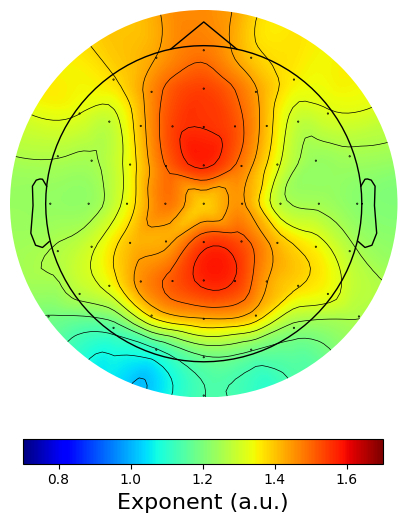

In [25]:
#plot exponent on a topomap
vlim = (.7, 1.7)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im, cm = plot_topomap(np.mean(np.array(results['exponent'])[good_mask], axis=0), chan_info, size=5, cmap='jet', show=False, contours=10, image_interp='cubic', axes=ax, vlim=vlim)
cbar_ax = fig.add_axes([0.15, 0.01, 0.72, 0.05])
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Exponent (a.u.)', fontsize=16)

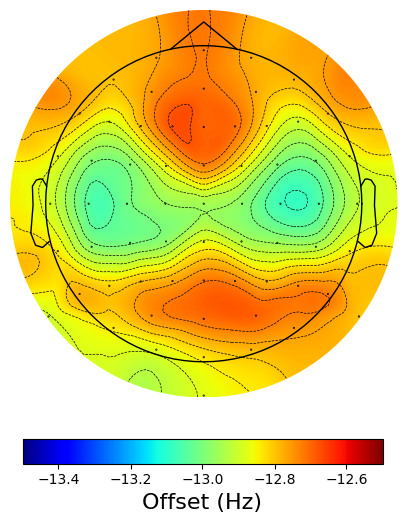

In [26]:
#plot offset on a topomap
vlim = (-13.5, -12.5)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im, cm = plot_topomap(np.mean(np.array(results['offset'])[good_mask], axis=0), chan_info, size=5, cmap='jet', show=False, contours=10, image_interp='cubic', axes=ax, vlim=vlim)
cbar_ax = fig.add_axes([0.15, 0.01, 0.72, 0.05])
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Offset (Hz)', fontsize=16)

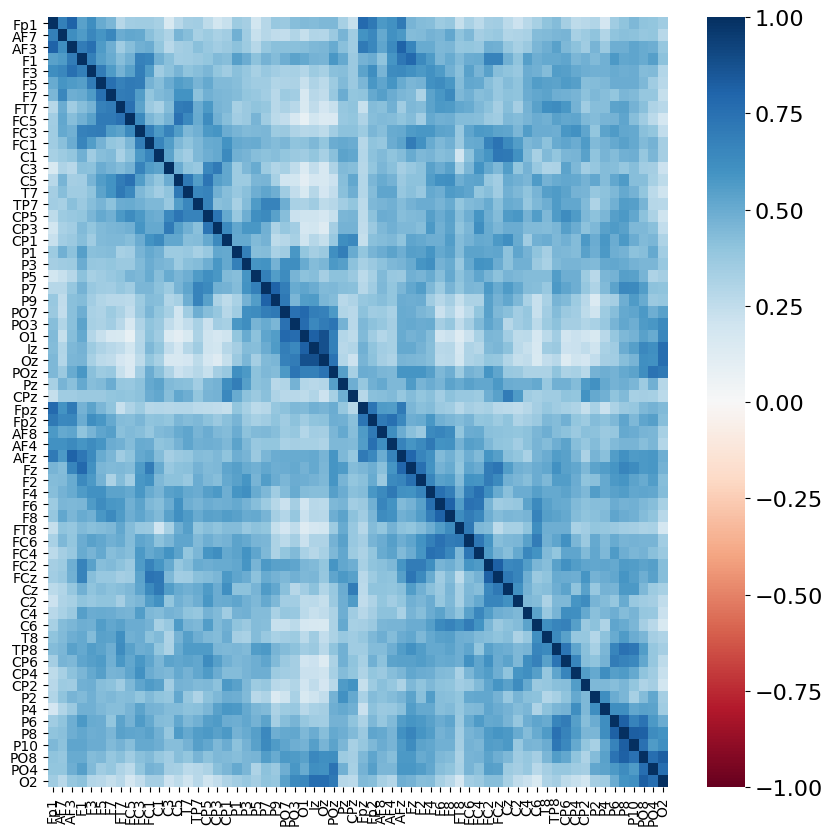

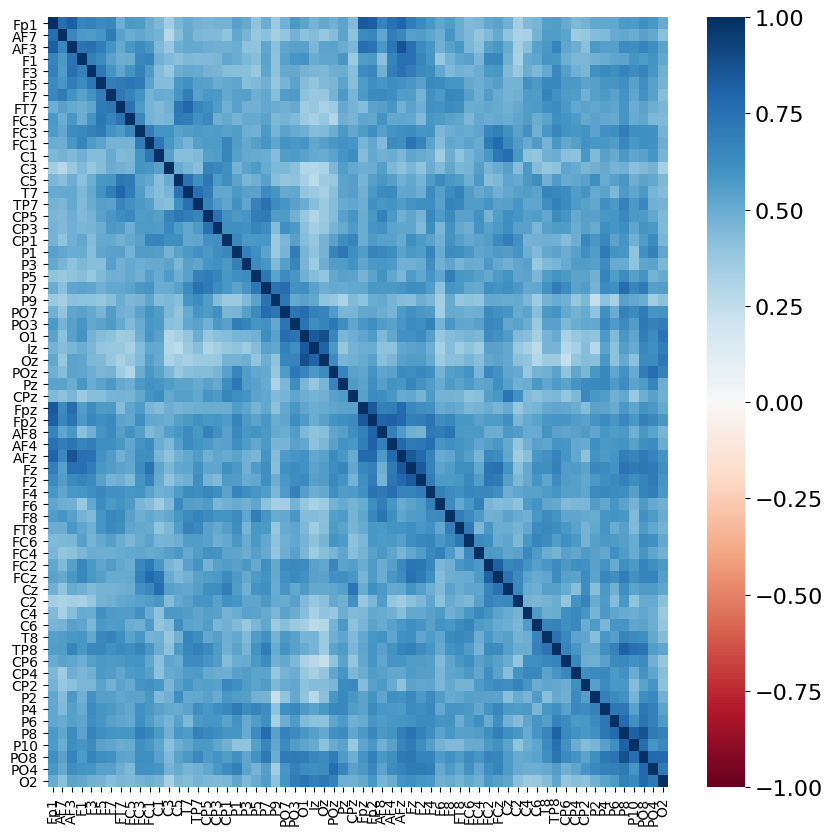

Frontal correlation: 0.6887416580591544
Parietal correlation: 0.6677610159526055


In [27]:
#Look at correlations of exponent and offset across the scalp
exponent_data = np.array(results['exponent'])
exponent_corr = np.corrcoef(exponent_data, rowvar=False)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(exponent_corr, cmap='RdBu', annot=False, fmt=".2f", cbar_kws={'label': ''}, xticklabels=chan_info['ch_names'], yticklabels=chan_info['ch_names'], vmin = -1, vmax = 1)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('')
plt.show()

offset_data = np.array(results['offset'])
offset_corr = np.corrcoef(offset_data, rowvar=False)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(offset_corr, cmap='RdBu', annot=False, fmt=".2f", cbar_kws={'label': ''}, xticklabels=chan_info['ch_names'], yticklabels=chan_info['ch_names'], vmin = -1, vmax = 1)
plt.title('')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.show()

#what are the average correlations values for the exponent_corr in the frontal and parietal locations?
frontal = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz']
parietal = ['P3', 'P4', 'P7', 'P8', 'Pz', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'O1', 'O2']

frontal_inds = [chan_info['ch_names'].index(ch) for ch in frontal]
parietal_inds = [chan_info['ch_names'].index(ch) for ch in parietal]

frontal_corr = np.mean(offset_corr[frontal_inds][:, frontal_inds])
parietal_corr = np.mean(offset_corr[parietal_inds][:, parietal_inds])

print("Frontal correlation:", frontal_corr)
print("Parietal correlation:", parietal_corr)

Perform PCA on the exponent and offset data

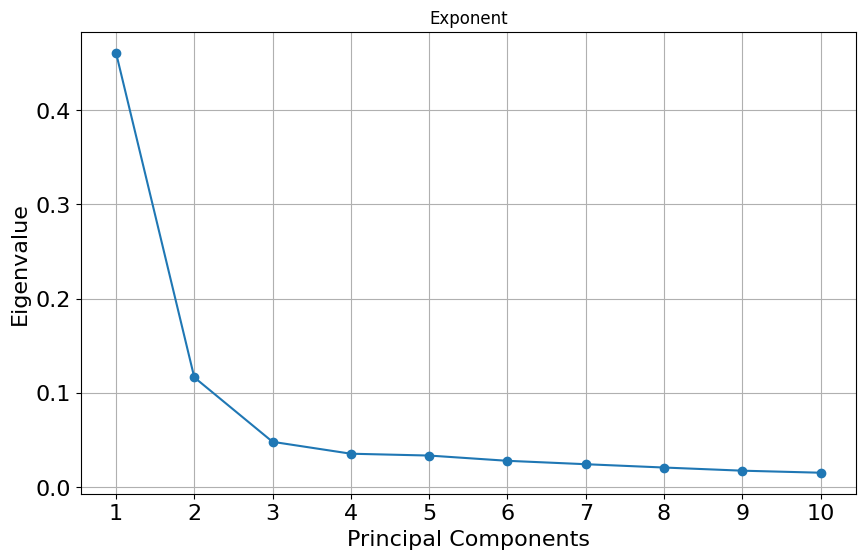

Explained variance: [0.46075391 0.11634887 0.04798732 0.03537096 0.03341779 0.02784879
 0.02423359 0.02071532 0.01736993 0.01520355]


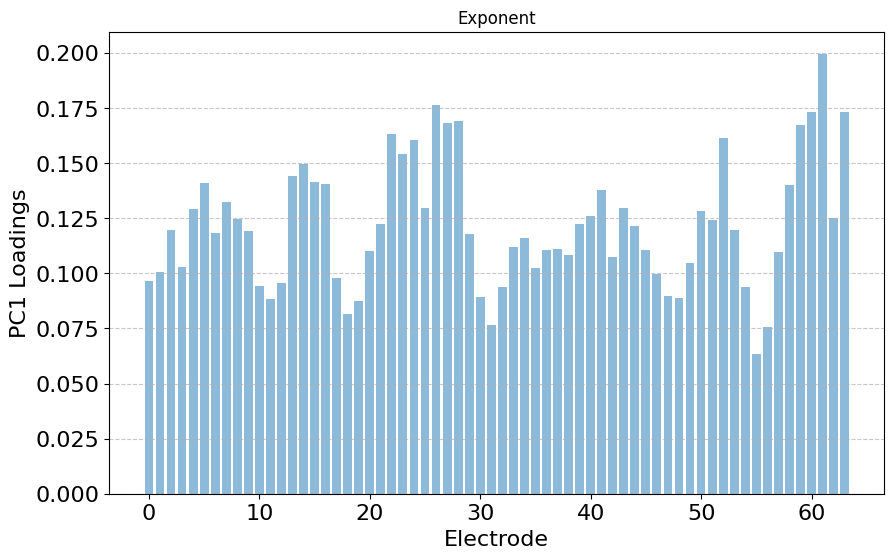

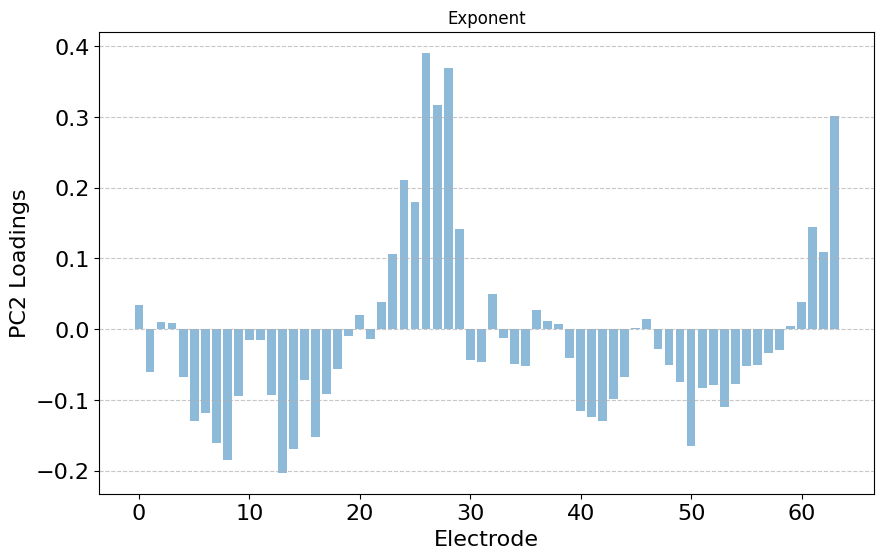

c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

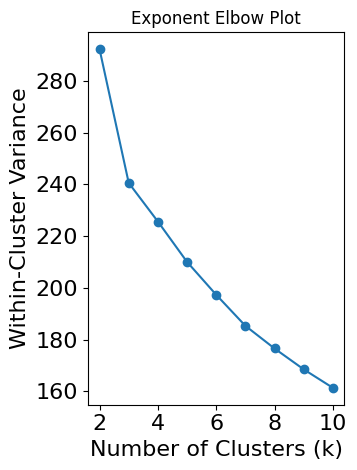

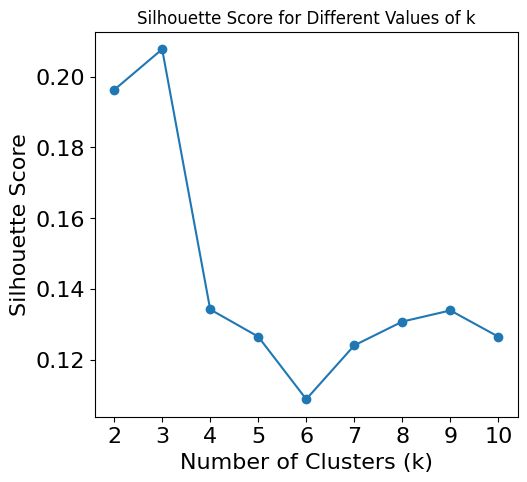

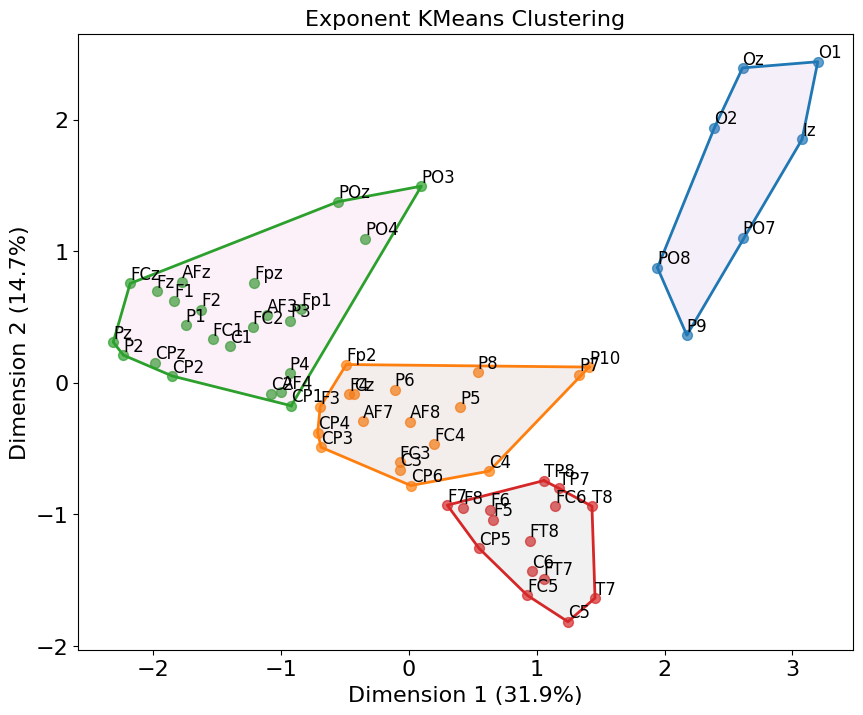

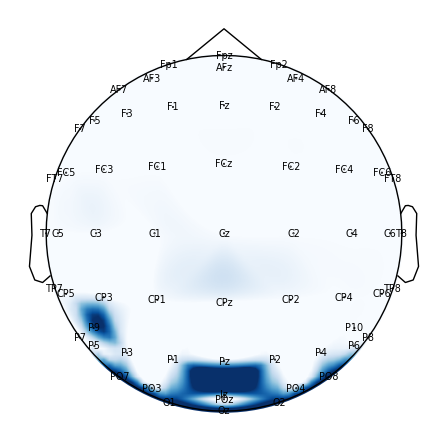

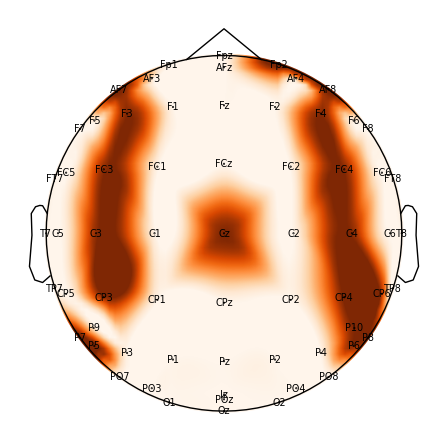

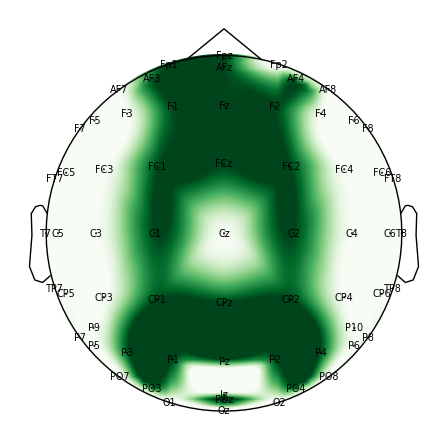

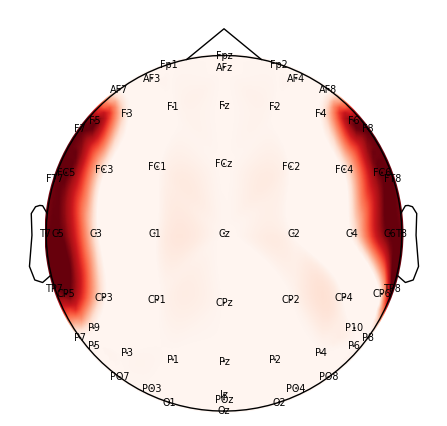

In [28]:
#Data reduction for exponent
pca = PCA(n_components=10)

#fit the PCA model
exp_pca = pca.fit(exponent_data)
exp_explained_variance = pca.explained_variance_ratio_
exp_cumulative_explained_variance = np.sum(exp_explained_variance)

#plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(exp_explained_variance) + 1), exp_explained_variance, marker='o', linestyle='-')
plt.title('Exponent')
plt.xlabel('Principal Components', fontsize = 16)
plt.ylabel('Eigenvalue', fontsize = 16)
plt.xticks(range(1, len(exp_explained_variance) + 1), fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(True)
plt.show()

print('Explained variance:', exp_explained_variance)
exp_loadings = pca.components_

# Plot the loadings for the PC1 component
plt.figure(figsize=(10, 6))
plt.bar(range(len(exp_loadings[0])), exp_loadings[0], align='center', alpha=0.5)
plt.title('Exponent')
plt.xlabel('Electrode', fontsize = 16)
plt.ylabel('PC1 Loadings', fontsize = 16)
plt.xticklabels = chan_info['ch_names']
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#plot the loadings for the PC2 component
plt.figure(figsize=(10, 6))
plt.bar(range(len(exp_loadings[1])), exp_loadings[1], align='center', alpha=0.5)
plt.title('Exponent')
plt.xlabel('Electrode', fontsize = 16)
plt.ylabel('PC2 Loadings', fontsize = 16)
plt.xticklabels = chan_info['ch_names']
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##Perform k-means clustering

exponent_data_transposed = exponent_data.T

# Define a range of values for k (number of clusters) to try
k_values = range(2, 11)

# Initialize lists to store silhouette scores and inertia
inertia_values = []
silhouette_scores = []

# Iterate over each value of k
for k in k_values:
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(exponent_data_transposed)
    # Compute inertia
    inertia_values.append(kmeans.inertia_)
    # Compute silhouette score
    silhouette_avg = silhouette_score(exponent_data_transposed, labels)
    silhouette_scores.append(silhouette_avg)

# Plot elbow plot
plt.subplot(1, 2, 2)
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)', fontsize = 16)
plt.ylabel('Within-Cluster Variance', fontsize = 16)
plt.title('Exponent Elbow Plot')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)', fontsize = 16)
plt.ylabel('Silhouette Score', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Silhouette Score for Different Values of k')

# Fit KMeans clustering model
kmeans = KMeansClustering(k=4)
labels = kmeans.fit(exponent_data_transposed, random_state=42)

#plot the data in clusters in the dimensions of pca 1 and pca2
# Fit PCA to your transposed exponent data
pca = PCA(n_components=2)
exponent_pca = pca.fit_transform(exponent_data_transposed)

# Create a scatter plot of the transformed data points, colored by cluster labels
plt.figure(figsize=(10, 8))
for cluster_num in np.unique(labels):
    cluster_points = exponent_pca[labels == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}', alpha=0.7, s=50)

    for i, (x, y) in enumerate(zip(cluster_points[:, 0], cluster_points[:, 1])):
        # Calculate the index of the electrode name in the list
        idx = np.where((exponent_pca[:, 0] == x) & (exponent_pca[:, 1] == y))[0][0]
        plt.text(x, y, chan_info['ch_names'][idx], fontsize=12, ha='left', va='bottom')

# Plot convex hull for each cluster
cluster_centers = kmeans.centroids
for i in range(len(cluster_centers)):
    cluster_points = exponent_pca[labels == i]
    hull = ConvexHull(cluster_points)

    plt.plot(np.append(cluster_points[hull.vertices, 0], cluster_points[hull.vertices[0], 0]),
             np.append(cluster_points[hull.vertices, 1], cluster_points[hull.vertices[0], 1]), 
             lw=2)
    plt.fill(np.append(cluster_points[hull.vertices, 0], cluster_points[hull.vertices[0], 0]), 
             np.append(cluster_points[hull.vertices, 1], cluster_points[hull.vertices[0], 1]), 
             alpha=0.1)  # Shade area

plt.xlabel('Dimension 1 (31.9%)', fontsize=16)
plt.ylabel('Dimension 2 (14.7%)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Exponent KMeans Clustering', fontsize=16)
plt.show()

#create a mask for the exponent values for each cluster
occipital_mask = labels == 0
frontoparietal_mask = labels == 1
midline_mask = labels == 2
central_mask = labels == 3

#calculate the mean exponent value for each cluster
occipital_exponent = np.mean(exponent_data_transposed[occipital_mask], axis=0)
frontoparietal_exponent = np.mean(exponent_data_transposed[frontoparietal_mask], axis=0)
midline_exponent = np.mean(exponent_data_transposed[midline_mask], axis=0)
central_exponent = np.mean(exponent_data_transposed[central_mask], axis=0)

#pull out the alpha peak freq data for each the exponent clusters
fooof_alpha_freq_data = np.array(results['fooof']['alpha'])[:,:,0].squeeze()
fooof_alpha_freq_data = fooof_alpha_freq_data.T
occipital_exp_fooof_alpha_freq = np.mean(fooof_alpha_freq_data[occipital_mask], axis=0)
frontoparietal_exp_fooof_alpha_freq = np.mean(fooof_alpha_freq_data[frontoparietal_mask], axis=0)
midline_exp_fooof_alpha_freq = np.mean(fooof_alpha_freq_data[midline_mask], axis=0)
central_exp_fooof_alpha_freq = np.mean(fooof_alpha_freq_data[central_mask], axis=0)

#Visualise the exponent clusters
chan_names = chan_info['ch_names']
positions = montage.get_positions()['ch_pos']
positions = {chan: pos for chan, pos in positions.items() if chan in chan_names}

colormaps = {
    'Occipital Cluster': 'Blues',
    'Frontoparietal Cluster': 'Oranges',
    'Midline Cluster': 'Greens',
    'Central Cluster': 'Reds'
}

plot_cluster_topomap(occipital_mask, 'Occipital Cluster', colormaps['Occipital Cluster'])
plot_cluster_topomap(frontoparietal_mask, 'Frontoparietal Cluster', colormaps['Frontoparietal Cluster'])
plot_cluster_topomap(midline_mask, 'Midline Cluster', colormaps['Midline Cluster'])
plot_cluster_topomap(central_mask, 'Central Cluster', colormaps['Central Cluster'])


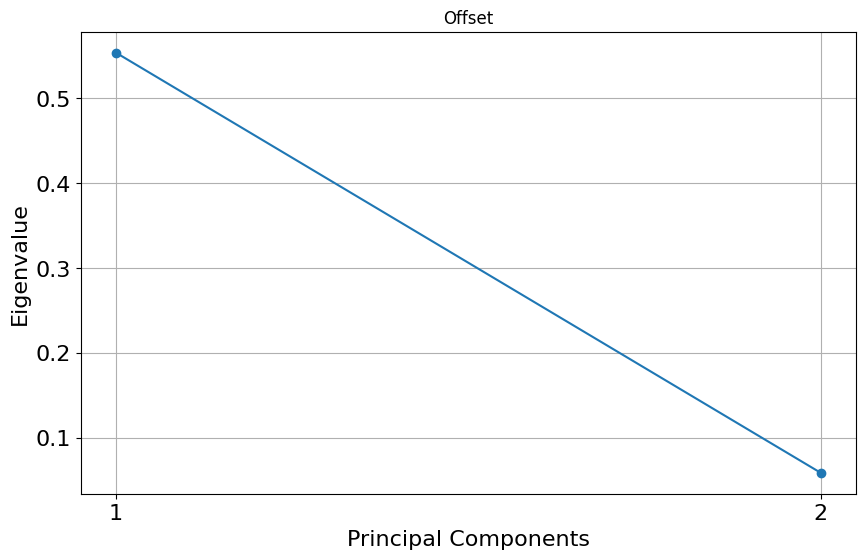

Explained variance: [0.55369491 0.05856057]


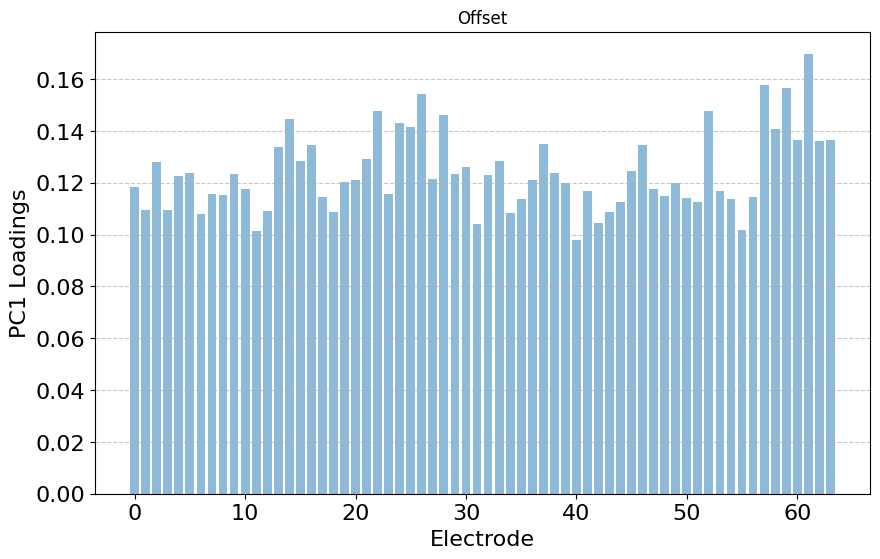

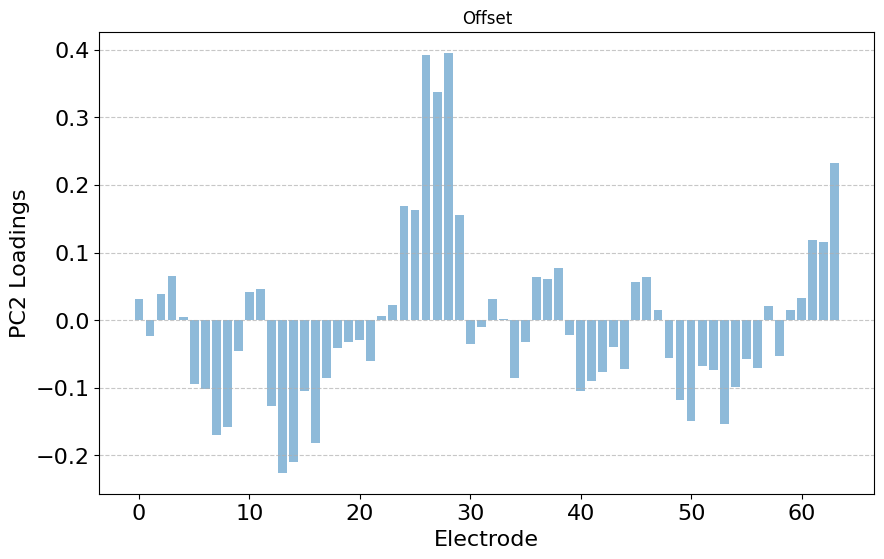

c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hypox\anaconda3\envs\EEG\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

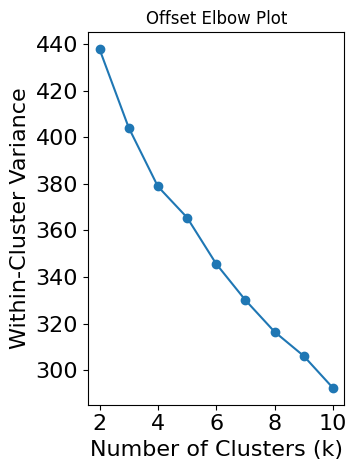

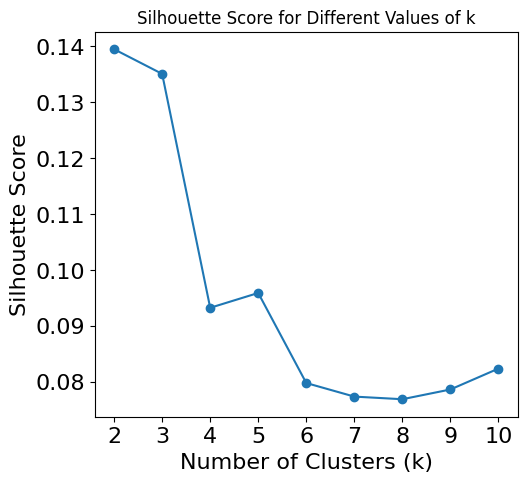

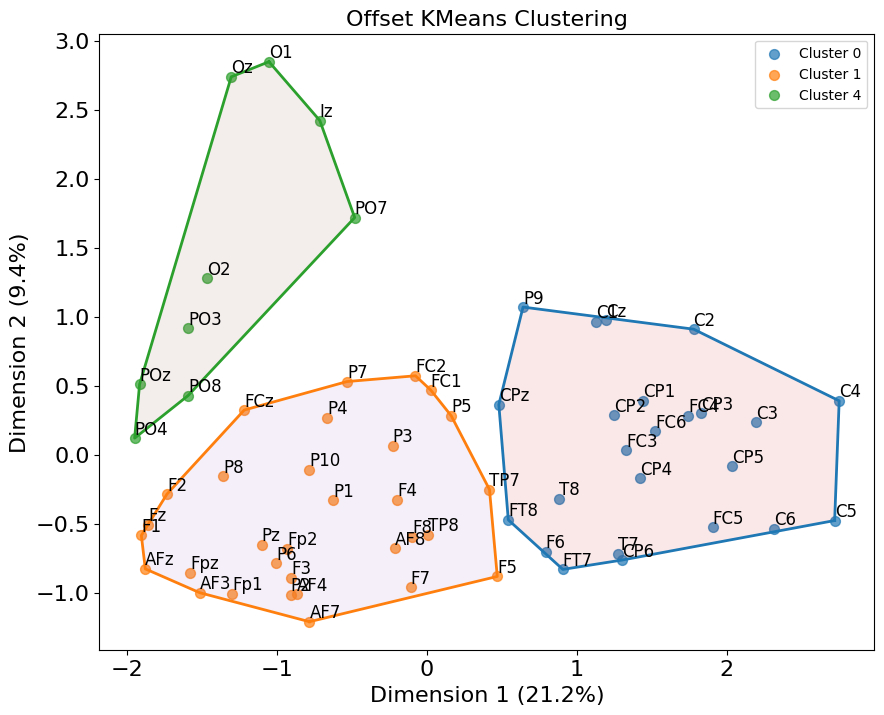

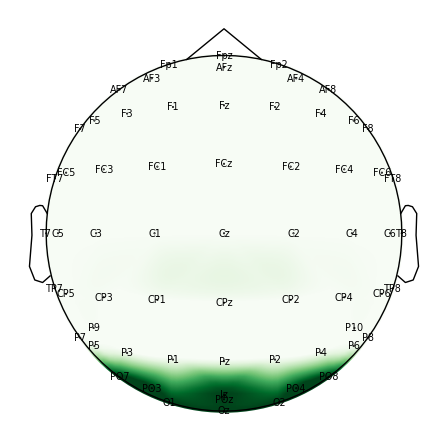

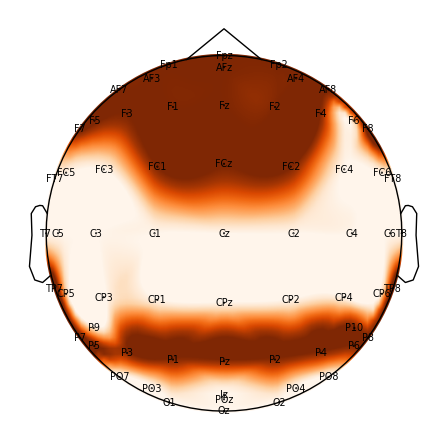

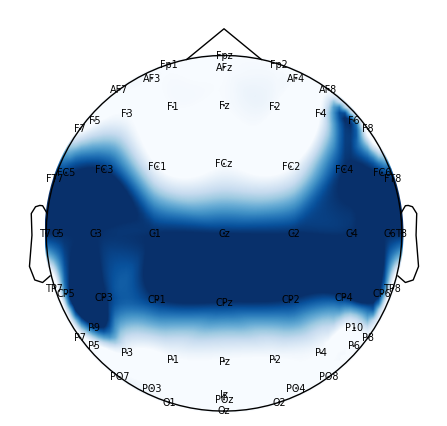

In [29]:
#Data reduction for offset

#fit the PCA model
off_pca = pca.fit(offset_data)
off_explained_variance = pca.explained_variance_ratio_
off_cumulative_explained_variance = np.cumsum(off_explained_variance)

#plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(off_explained_variance) + 1), off_explained_variance, marker='o', linestyle='-')
plt.title('Offset')
plt.xlabel('Principal Components', fontsize =16)
plt.ylabel('Eigenvalue', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks(range(1, len(off_explained_variance) + 1))
plt.grid(True)
plt.show()

print('Explained variance:', off_explained_variance)

# Plot the loadings for the PC1 component
off_loadings = pca.components_
plt.figure(figsize=(10, 6))
plt.bar(range(len(off_loadings[0])), off_loadings[0], align='center', alpha=0.5)
plt.title('Offset')
plt.xlabel('Electrode', fontsize = 16)
plt.ylabel('PC1 Loadings', fontsize = 16)
plt.xticklabels = chan_info['ch_names']
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#plot the loadings for the PC2 component
plt.figure(figsize=(10, 6))
plt.bar(range(len(off_loadings[1])), off_loadings[1], align='center', alpha=0.5)
plt.title('Offset')
plt.xlabel('Electrode', fontsize = 16)
plt.ylabel('PC2 Loadings', fontsize = 16)
plt.xticklabels = chan_info['ch_names']
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Perform k-means clustering for offset
offset_data_transposed = offset_data.T
k_values = range(2, 11)
inertia_values = []
silhouette_scores = []

# Iterate over each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(offset_data_transposed)
    inertia_values.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(offset_data_transposed, labels)
    silhouette_scores.append(silhouette_avg)

# Plot elbow plot
plt.subplot(1, 2, 2)
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)', fontsize = 16)
plt.ylabel('Within-Cluster Variance', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Offset Elbow Plot')
plt.tight_layout()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)', fontsize = 16)
plt.ylabel('Silhouette Score', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Silhouette Score for Different Values of k')


# Fit KMeans clustering model
kmeans = KMeansClustering(k=5)
labels = kmeans.fit(offset_data_transposed, random_state=42)

#plot the data in clusters in the dimensions of pca 1 and pca2
# Fit PCA to your transposed exponent data
pca = PCA(n_components=2)
offset_pca = pca.fit_transform(offset_data_transposed)

plt.figure(figsize=(10, 8))
for cluster_num in np.unique(labels):
    cluster_points = offset_pca[labels == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}', alpha=0.7, s=50)

    for i, (x, y) in enumerate(zip(cluster_points[:, 0], cluster_points[:, 1])):
        # Calculate the index of the electrode name in the list
        idx = np.where((offset_pca[:, 0] == x) & (offset_pca[:, 1] == y))[0][0]
        plt.text(x, y, chan_info['ch_names'][idx], fontsize=12, ha='left', va='bottom')


# Plot convex hull for each cluster
cluster_centers = kmeans.centroids

for i in range(len(cluster_centers)):
    cluster_points = offset_pca[labels == i]
    
    if len(cluster_points) > 0:
        hull = ConvexHull(cluster_points)
        
        plt.plot(np.append(cluster_points[hull.vertices, 0], cluster_points[hull.vertices[0], 0]),
                 np.append(cluster_points[hull.vertices, 1], cluster_points[hull.vertices[0], 1]), 
                 lw=2)
        
        plt.fill(np.append(cluster_points[hull.vertices, 0], cluster_points[hull.vertices[0], 0]), 
                 np.append(cluster_points[hull.vertices, 1], cluster_points[hull.vertices[0], 1]), 
                 alpha=0.1)  # Shade area

plt.xlabel('Dimension 1 (21.2%)', fontsize=16)
plt.ylabel('Dimension 2 (9.4%)', fontsize=16)
plt.title('Offset KMeans Clustering', fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend()
plt.show()

#create a mask for the offset values for each cluster
occipital_mask = labels == 4
frontoparietal_mask = labels == 1
central_mask = labels == 0

#calculate the mean offset value for each cluster
occipital_offset = np.mean(offset_data_transposed[occipital_mask], axis=0)
frontoparietal_offset = np.mean(offset_data_transposed[frontoparietal_mask], axis=0)
central_offset = np.mean(offset_data_transposed[central_mask], axis=0)
fooof_alpha_freq_data = np.array(results['fooof']['alpha'])[:,:,0].squeeze()
fooof_alpha_freq_data = fooof_alpha_freq_data.T
occipital_off_fooof_alpha_freq = np.mean(fooof_alpha_freq_data[occipital_mask], axis=0)
frontoparietal_off_fooof_alpha_freq = np.mean(fooof_alpha_freq_data[frontoparietal_mask], axis=0)
central_off_fooof_alpha_freq = np.mean(fooof_alpha_freq_data[central_mask], axis=0)

#Visualise the offset clusters
positions = {chan: pos for chan, pos in positions.items() if chan in chan_names}

# Define colormaps for each cluster
colormaps = {
    'Occipital Cluster': 'Greens',
    'Frontoparietal Cluster': 'Oranges',
    'Central Cluster': 'Blues'
}

# Plotting each cluster with its specified colormap
plot_cluster_topomap(occipital_mask, 'Occipital Cluster', colormaps['Occipital Cluster'])
plot_cluster_topomap(frontoparietal_mask, 'Frontoparietal Cluster', colormaps['Frontoparietal Cluster'])
plot_cluster_topomap(central_mask, 'Central Cluster', colormaps['Central Cluster'])


In [30]:
#Create the cognitive tests
demo_data['CWIT'] = demo_data[['cw_1', 'cw_2', 'cw_3', 'cw_4']].mean(axis=1)
demo_data['WAIS_DST'] = demo_data['ds_tot']
demo_data['RAVLT'] = demo_data[['ravlt_tot','ravlt_imm','ravlt_del']].mean(axis=1)
demo_data['DKEFS'] = demo_data[['tmt_2', 'tmt_3', 'tmt_4']].mean(axis=1)
demo_data['VFT'] = demo_data[['vf_1', 'vf_2', 'vf_3']].mean(axis=1)

combined_data = demo_data.copy()

combined_data['CWIT'] = replace_nans(combined_data['CWIT'])
combined_data['WAIS_DST'] = replace_nans(combined_data['WAIS_DST'])
combined_data['RAVLT'] = replace_nans(combined_data['RAVLT'])
combined_data['DKEFS'] = replace_nans(combined_data['DKEFS'])
combined_data['VFT'] = replace_nans(combined_data['VFT'])

#general aperiodic factor data
combined_data['exponent_average'] = replace_nans(np.array(results['exponent']).mean(axis=1))
combined_data['offset_average'] = replace_nans(np.array(results['offset']).mean(axis=1))

#cluster specific data
combined_data['frontoparietal_exponent'] = replace_nans(frontoparietal_exponent)
combined_data['central_exponent'] = replace_nans(central_exponent)
combined_data['midline_exponent'] = replace_nans(midline_exponent)
combined_data['occipital_exponent'] = replace_nans(occipital_exponent)
combined_data['frontoparietal_offset'] = replace_nans(frontoparietal_offset)
combined_data['central_offset'] = replace_nans(central_offset)
combined_data['occipital_offset'] = replace_nans(occipital_offset)

#remove any participants with aperiodic values that are 3 standard deviations from the mean
combined_data = combined_data[(np.abs(combined_data['occipital_exponent'] - combined_data['occipital_exponent'].mean()) / combined_data['occipital_exponent'].std() < 3)]
combined_data = combined_data[(np.abs(combined_data['frontoparietal_exponent'] - combined_data['frontoparietal_exponent'].mean()) / combined_data['frontoparietal_exponent'].std() < 3)]
combined_data = combined_data[(np.abs(combined_data['midline_exponent'] - combined_data['midline_exponent'].mean()) / combined_data['midline_exponent'].std() < 3)]
combined_data = combined_data[(np.abs(combined_data['central_exponent'] - combined_data['central_exponent'].mean()) / combined_data['central_exponent'].std() < 3)]
combined_data = combined_data[(np.abs(combined_data['occipital_offset'] - combined_data['occipital_offset'].mean()) / combined_data['occipital_offset'].std() < 3)]
combined_data = combined_data[(np.abs(combined_data['frontoparietal_offset'] - combined_data['frontoparietal_offset'].mean()) / combined_data['frontoparietal_offset'].std() < 3)]
combined_data = combined_data[(np.abs(combined_data['central_offset'] - combined_data['central_offset'].mean()) / combined_data['central_offset'].std() < 3)]

combined_data.to_csv('combined_data.csv', index=False)

# =============================================================================
# Correlations and robust models. If working from the provided "combined_data.csv" file, start here.
# =============================================================================

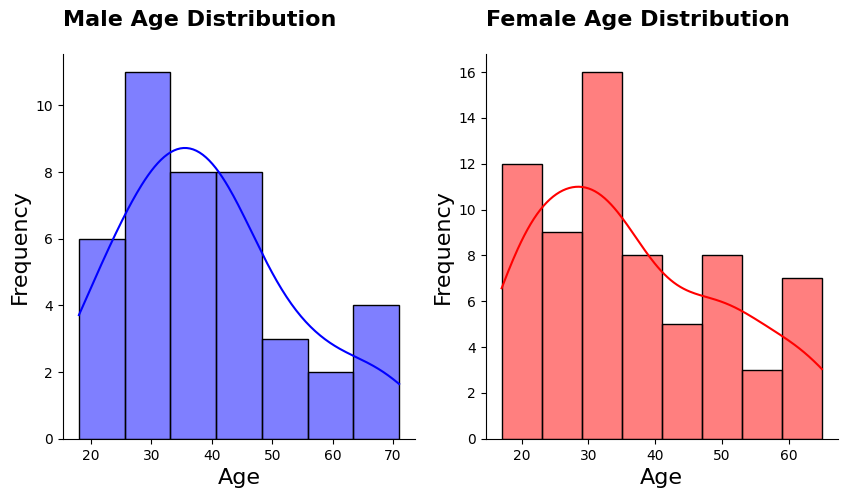

In [31]:
#seperate the data by SexN
male_data = combined_data[combined_data['SexN'] == 1]
female_data = combined_data[combined_data['SexN'] == 0]

# Plot two histograms of the age data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted the figure size for better display

# Plot male data on the first axis
sns.histplot(male_data['age'], kde=True, ax=axs[0], color='blue')
axs[0].set_title("Male Age Distribution", loc = 'left', fontsize=16, fontweight='bold', color='black', pad=20)
axs[0].set_xlabel('Age', fontsize=16, color = 'black')
axs[0].set_ylabel('Frequency', fontsize=16, color = 'black')


#make the font size bigger

# Plot female data on the second axis
sns.histplot(female_data['age'], kde=True, ax=axs[1], color='red')
axs[1].set_title("Female Age Distribution", loc = 'left', fontsize=16, fontweight='bold', color='black', pad=20)
axs[1].set_xlabel('Age', fontsize=16, color = 'black')
axs[1].set_ylabel('Frequency', fontsize=16, color = 'black')

#despine the plot
sns.despine()

                            OLS Regression Results                            
Dep. Variable:         central_offset   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     10.16
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           6.15e-06
Time:                        09:48:45   Log-Likelihood:                 3.7458
No. Observations:                 110   AIC:                            0.5084
Df Residuals:                     106   BIC:                             11.31
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.1999      0.325    -37.552      0.0

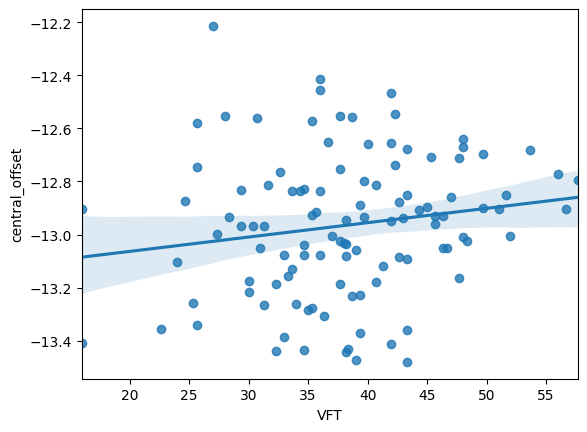

In [33]:
import statsmodels.api as sm
#Bivariate and partial correlations
x_var = 'VFT'
y_var = 'central_offset'

sns.regplot(x=x_var, y=y_var, data=combined_data)
pg.partial_corr(data=combined_data, x=x_var, y=y_var, covar='age', method='pearson')

#Ordinary least squares model
formula = f"{y_var} ~ {x_var} + age + {x_var} * age"
model = smf.ols(formula, data=combined_data)
results = model.fit()
print(results.summary())

#Robust model
r_model = smf.rlm(formula, data=combined_data, M=sm.robust.norms.LeastSquares())
r_results = r_model.fit()
print(r_results.summary())

For calculating multiple comparisons corrected p-values for bivariate and partial correlations

In [36]:
# Load the necessary libraries
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# Select specific variables for correlation
selected_vars = combined_data[[
    "age",
    "exponent_average",
    "offset_average",
    "frontoparietal_exponent",
    "central_exponent",
    "midline_exponent",
    "occipital_exponent",
    "frontoparietal_offset",
    "central_offset",
    "occipital_offset",
    "CWIT",
    "WAIS_DST",
    "RAVLT",
    "DKEFS",
    "VFT"
]]

# Initialize a list to store results
bivar_results = []

# Calculate the bivariate correlation coefficients and p-values
for i in range(len(selected_vars.columns) - 1):
    for j in range(i + 1, len(selected_vars.columns)):
        corr, p_value = pearsonr(selected_vars.iloc[:, i], selected_vars.iloc[:, j])
        bivar_results.append({
            'Var1': selected_vars.columns[i],
            'Var2': selected_vars.columns[j],
            'Correlation': corr,
            'P.Value': p_value
        })

# Create a DataFrame from the results
bivar_results_df = pd.DataFrame(bivar_results)

# Correct for multiple comparisons using FDR
bivar_results_df['Corrected.P.Value'] = multipletests(bivar_results_df['P.Value'], method='fdr_bh')[1]
bivar_results_df = pd.DataFrame(bivar_results_df)

#save the bivar_results to a csv
bivar_results_df.to_csv('correlation_results.csv', index=False)

#Calculate the partial correlations controlling for age
from pingouin import partial_corr

# Initialize a list to store results
partial_corr_results = []

# Select specific variables for correlation
selected_vars = combined_data[[
    "exponent_average",
    "offset_average",
    "frontoparietal_exponent",
    "central_exponent",
    "midline_exponent",
    "occipital_exponent",
    "frontoparietal_offset",
    "central_offset",
    "occipital_offset",
    "CWIT",
    "WAIS_DST",
    "RAVLT",
    "DKEFS",
    "VFT"
]]
# Calculate the partial correlation coefficients and p-values
for i in range(len(selected_vars.columns) - 1):
    for j in range(i + 1, len(selected_vars.columns)):
        partial_corr_res = partial_corr(
            data=combined_data,
            x=selected_vars.columns[i],
            y=selected_vars.columns[j],
            covar='age'
        )
        partial_corr_results.append({
            'Var1': selected_vars.columns[i],
            'Var2': selected_vars.columns[j],
            'Partial.Correlation': partial_corr_res['r'][0],
            'P.Value': partial_corr_res['p-val'][0]
        })

# Create a DataFrame from the results
partial_corr_results_df = pd.DataFrame(partial_corr_results)

# Correct for multiple comparisons using FDR
partial_corr_results_df['Corrected.P.Value'] = multipletests(partial_corr_results_df['P.Value'], method='fdr_bh')[1]
partial_corr_results_df = pd.DataFrame(partial_corr_results_df)

#save the partial_corr_results to a csv
partial_corr_results_df.to_csv('partial_correlation_results.csv', index=False)

C:\Users\Hypox\AppData\Local\Temp\ipykernel_19544\921082547.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Partial.Correlation': partial_corr_res['r'][0],
C:\Users\Hypox\AppData\Local\Temp\ipykernel_19544\921082547.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P.Value': partial_corr_res['p-val'][0]
C:\Users\Hypox\AppData\Local\Temp\ipykernel_19544\921082547.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Partial

For calculating multiple comparisons corrected p-values for robust regression models

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import false_discovery_control

# Define your EEG variable and cognitive tests
eeg_variable = 'occipital_offset'  # Specify your EEG variable
cognitive_tests = ['CWIT', 'WAIS_DST', 'RAVLT', 'DKEFS', 'VFT']  # Replace with actual test names

# Initialize separate lists for each type of p-values
ap_activity_p_values = []  # Main effects of aperiodic activity
age_p_values = []          # Main effects of age
interaction_p_values = []  # Interaction effects

# Loop over each cognitive test
for test in cognitive_tests:
    formula = f"{test} ~ {eeg_variable} + age + {eeg_variable} * age"
    
    # Robust linear model
    model = smf.rlm(formula, data=combined_data)
    results = model.fit()
    
    # Extract p-values for main effects and interaction term
    ap_activity_p_values.append(results.pvalues[eeg_variable])  # Main effect of EEG variable
    age_p_values.append(results.pvalues['age'])                 # Main effect of age
    interaction_p_values.append(results.pvalues[f'{eeg_variable}:age'])  # Interaction term

# Apply FDR correction separately for each category using scipy
ap_activity_corrected = false_discovery_control(ap_activity_p_values, method='bh')
age_corrected = false_discovery_control(age_p_values, method='bh')
interaction_corrected = false_discovery_control(interaction_p_values, method='bh')

# Print corrected p-values
print("\nCorrected Aperiodic Activity Main Effects p-values:", ap_activity_corrected)
print("\nCorrected Age Main Effects p-values:", age_corrected)
print("\nCorrected Interaction Effects p-values:", interaction_corrected)


Corrected Aperiodic Activity Main Effects p-values: [0.83834826 0.83834826 0.83834826 0.83834826 0.47854477]

Corrected Age Main Effects p-values: [0.72833626 0.82612326 0.82612326 0.72833626 0.0175541 ]

Corrected Interaction Effects p-values: [0.64579551 0.77623964 0.77623964 0.59961393 0.01887613]


# =============================================================================
# Simple slopes and Johnson-Neyman plots are conducted in R.
# =============================================================================